# <font color="#1d479b">Contexte</font>

Pour atteindre l'objectif de **ville neutre en émissions de carbone en 2050**, la ville de **Seattle** s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.



## 1. **Importer les bibliothèques :**

In [55]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from category_encoders import TargetEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
# Ignorer les avertissements spécifiques de mauvaise condition de matrice
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Importation des nouveaux modèles
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pickle
import shap

## 2. **Charger le jeu de donnée:**

In [56]:
# Charger les dtypes depuis le fichier JSON
with open("Data/dtypes_EnergyUse.json", "r") as f:
    dtypes_dict = json.load(f)

data = pd.read_csv("Data/building-EnergyUse-cleaned.csv", dtype=dtypes_dict)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,...,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup,DistanceToCenter,SiteEnergyUse(kBtu)_log
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,60.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.800050,15.793246
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,61.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas,0.787077,15.942305
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,43.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas,0.970109,18.100297
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,56.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.944139,15.731637
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,75.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas,1.048092,16.466822


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   OSEBuildingID                               1387 non-null   object 
 1   BuildingType                                1387 non-null   object 
 2   PrimaryPropertyType                         1387 non-null   object 
 3   ZipCode                                     1387 non-null   object 
 4   CouncilDistrictCode                         1387 non-null   object 
 5   Neighborhood                                1387 non-null   object 
 6   LargestPropertyUseType                      1387 non-null   object 
 7   SecondLargestPropertyUseType                1387 non-null   object 
 8   ThirdLargestPropertyUseType                 1387 non-null   object 
 9   ENERGYSTARScore                             930 non-null    float64
 10  TotalUseType

In [58]:
data.describe()

,ENERGYSTARScore,TotalUseTypeNumber,BuildingAge,Building(s)_Proportion,Parking_Proportion,LargestPropertyUse_Proportion,SecondLargestPropertyUse_Proportion,ThirdLargestPropertyUse_Proportion,GFAPerBuilding,GFAPerFloor,DistanceToCenter,SiteEnergyUse(kBtu)_log
count,930.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1.387000e+03,1.387000e+03,1387.000000,1387.000000
mean,63.858065,1.790195,54.313627,0.937344,0.062656,0.892138,0.113059,0.010797,1.067024e+05,3.379830e+04,4.428125,14.943611
std,28.584083,1.029839,32.267624,0.140386,0.140386,0.301025,0.162748,0.033702,1.884490e+05,5.051379e+04,3.544913,1.313674
min,1.000000,1.000000,1.000000,0.201833,0.000000,0.237640,0.000000,0.000000,0.000000e+00,0.000000e+00,0.034028,10.953158
25%,44.250000,1.000000,28.000000,1.000000,0.000000,0.730754,0.000000,0.000000,2.684650e+04,1.296000e+04,1.365118,14.032829
50%,71.000000,2.000000,51.000000,1.000000,0.000000,0.965856,0.000000,0.000000,4.475500e+04,2.228200e+04,3.422816,14.816230
75%,88.000000,2.000000,86.000000,1.000000,0.000000,1.000000,0.206836,0.000000,9.927750e+04,3.684460e+04,6.730087,15.803131
max,100.000000,11.000000,116.000000,1.000000,0.798167,6.426849,1.452054,0.405751,2.200000e+06,1.100000e+06,14.242219,20.588504


## 3. Sélection des variables numériques et catégorielles:


Nous allons séparer les données numériques et les données catégorielles de notre dataset :

In [59]:
numerical_features = data.select_dtypes(include=['int32','int64','float64'])
categorical_features = data.select_dtypes(exclude=['int32','int64','float64']) 

In [60]:
categorical_features

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ElectricityUseCategory_PrimaryPropertyType,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,50208,Nonresidential COS,Other,981174,6,BALLARD,Recreation,Recreation,Commercial,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas
1383,50212,Nonresidential COS,Other,981125,3,EAST,Recreation,Missing,Missing,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Low_elec,Zero_steam,Low_gas
1384,50221,Nonresidential COS,Other,981267,1,DELRIDGE NEIGHBORHOODS,Recreation,Missing,Missing,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas
1385,50223,Nonresidential COS,Other,000000,2,DOWNTOWN,Recreation,Missing,Missing,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,High_elec,Zero_steam,High_gas


Pour les données catégorielles, nous allons devoir encoder les valeurs. Séparer les variables pouvant être encodées en OneHot des autres:

In [61]:
categorical_features.nunique()

OSEBuildingID                                 1387
BuildingType                                     5
PrimaryPropertyType                             17
ZipCode                                         54
CouncilDistrictCode                              7
Neighborhood                                    19
LargestPropertyUseType                           9
SecondLargestPropertyUseType                    10
ThirdLargestPropertyUseType                      9
ElectricityUseCategory_PrimaryPropertyType       4
SteamUseCategory_PrimaryPropertyType             5
NaturalGasUseCategory_PrimaryPropertyType        4
ElectricityUseCategory_BuildingType              4
SteamUseCategory_BuildingType                    4
NaturalGasUseCategory_BuildingType               4
ElectricityUseCategory_AgeGroup                  4
SteamUseCategory_AgeGroup                        5
NaturalGasUseCategory_AgeGroup                   4
dtype: int64

In [62]:
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,...,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup,DistanceToCenter,SiteEnergyUse(kBtu)_log
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,60.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.800050,15.793246
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,61.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas,0.787077,15.942305
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,43.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas,0.970109,18.100297
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,56.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.944139,15.731637
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,75.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas,1.048092,16.466822


Regardons maintenant les données numériques :

In [63]:
list(numerical_features.columns)

['ENERGYSTARScore',
 'TotalUseTypeNumber',
 'BuildingAge',
 'Building(s)_Proportion',
 'Parking_Proportion',
 'LargestPropertyUse_Proportion',
 'SecondLargestPropertyUse_Proportion',
 'ThirdLargestPropertyUse_Proportion',
 'GFAPerBuilding',
 'GFAPerFloor',
 'DistanceToCenter',
 'SiteEnergyUse(kBtu)_log']

In [64]:
numerical_features

,ENERGYSTARScore,TotalUseTypeNumber,BuildingAge,Building(s)_Proportion,Parking_Proportion,LargestPropertyUse_Proportion,SecondLargestPropertyUse_Proportion,ThirdLargestPropertyUse_Proportion,GFAPerBuilding,GFAPerFloor,DistanceToCenter,SiteEnergyUse(kBtu)_log
0,60.0,1,89,1.000000,0.000000,1.000000,0.000000,0.000000,88434.0,7369.500,0.800050,15.793246
1,61.0,3,20,0.854547,0.145453,0.809918,0.145453,0.044629,103566.0,9415.091,0.787077,15.942305
2,43.0,1,47,0.794252,0.205748,0.791220,0.000000,0.000000,956110.0,23319.756,0.970109,18.100297
3,56.0,1,90,1.000000,0.000000,1.000000,0.000000,0.000000,61320.0,6132.000,0.944139,15.731637
4,75.0,3,36,0.646885,0.353115,0.703070,0.387339,0.000000,175580.0,9754.444,1.048092,16.466822
...,...,...,...,...,...,...,...,...,...,...,...,...
1382,NaN,4,44,1.000000,0.000000,0.854570,0.130785,0.014645,12769.0,12769.000,8.573816,15.448139
1383,NaN,1,104,1.000000,0.000000,1.000000,0.000000,0.000000,23445.0,23445.000,3.148550,15.603303
1384,NaN,1,34,1.000000,0.000000,1.000000,0.000000,0.000000,18261.0,18261.000,7.947873,13.745177
1385,NaN,1,12,1.000000,0.000000,1.000000,0.000000,0.000000,16000.0,16000.000,1.306590,13.764509


## 3. bis Choix de l'encodage entre TargetEncoder et OneHotEncoder:

In [65]:
# Séparation des features et de la cible
X = data.drop(['SiteEnergyUse(kBtu)_log', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)
y_site_energy = data['SiteEnergyUse(kBtu)_log']

# Identification des features numériques et catégoriques
numeric_features = X.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['int32', 'int64', 'float64']).columns.tolist()

def test_encoding(model, X, y):
    # Pipeline pour les variables numériques
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Préprocesseurs et pipelines pour Target et One Hot Encoding
    preprocessors = {
        'target': ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('target_encoder', TargetEncoder())
            ]), categorical_features)
        ]),
        'onehot': ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])
    }

    results = {}
    for enc_type, preprocessor in preprocessors.items():
        # Création et entraînement du pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        pipeline.fit(X_train, y_train)
        
        # Évaluation sur l'ensemble de test
        y_pred = pipeline.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        results[enc_type] = {'R2': r2, 'RMSE': rmse}

    return results

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y_site_energy, test_size=0.2, random_state=42)

# Test uniquement avec des modèles non linéaires
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(),
    'GradientBoost': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

final_results = {}
for name, model in models.items():
    print(f"Testing {name}")
    results = test_encoding(model, X_train, y_train)
    final_results[name] = results
    print(f"Results for {name}: {results}")

# Comparaison et sélection de la meilleure méthode
# Calcul des moyennes des R² et RMSE pour chaque méthode de codage
average_r2 = {}
average_rmse = {}
for model_results in final_results.values():
    for enc_type, scores in model_results.items():
        average_r2[enc_type] = average_r2.get(enc_type, 0) + scores['R2']
        average_rmse[enc_type] = average_rmse.get(enc_type, 0) + scores['RMSE']

# Moyenne sur le nombre de modèles testés
num_models = len(models)
average_r2 = {k: v / num_models for k, v in average_r2.items()}
average_rmse = {k: v / num_models for k, v in average_rmse.items()}

if average_r2['target'] > average_r2['onehot'] and average_rmse['target'] < average_rmse['onehot']:
    print("Target Encoding est la meilleure méthode selon le R² et le RMSE.")
else:
    print("One Hot Encoding est la meilleure méthode selon le R² et le RMSE.")




Testing RandomForest
Results for RandomForest: {'target': {'R2': 0.7461040164144044, 'RMSE': 0.6331771272146598}, 'onehot': {'R2': 0.7556328677913305, 'RMSE': 0.6211817655799657}}
Testing XGBoost
Results for XGBoost: {'target': {'R2': 0.7240262774976904, 'RMSE': 0.6601325818279782}, 'onehot': {'R2': 0.7403415610656203, 'RMSE': 0.6403221476725509}}
Testing GradientBoost
Results for GradientBoost: {'target': {'R2': 0.7371466727012699, 'RMSE': 0.6442494287484519}, 'onehot': {'R2': 0.7635711093135273, 'RMSE': 0.6110089544831603}}
One Hot Encoding est la meilleure méthode selon le R² et le RMSE.


**Conclusion :**

- Le One Hot Encoding s'est avéré être la meilleure méthode d'encodage pour les modèles non linéaires testés—RandomForest, XGBoost et GradientBoost—sur cet ensemble de données spécifique. Il a systématiquement produit des scores R² plus élevés et des valeurs RMSE plus basses comparé au Target Encoding. Cette méthode est privilégiée pour sa capacité à gérer les caractéristiques catégorielles de manière neutre sans introduire de biais, ce qui est essentiel pour les modèles non linéaires. Le One Hot Encoding démontre ainsi sa robustesse et sa transparence, rendant cette approche particulièrement efficace et fiable pour les modèles considérés.


## 4. Simulation des modèles linéaires simples : 'Ridge', 'Lasso', 'ElasticNet' et 'Dummy Regressor':


### 4. 1. Sélection des variables explicatives et des variables cibles

In [66]:
X = data.drop(['SiteEnergyUse(kBtu)_log', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)
y_site_energy = data['SiteEnergyUse(kBtu)_log']

In [67]:
display(X.head())

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,TotalUseTypeNumber,BuildingAge,...,ElectricityUseCategory_PrimaryPropertyType,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup,DistanceToCenter
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,1,89,...,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.800050
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,3,20,...,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas,0.787077
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,1,47,...,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas,0.970109
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,1,90,...,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.944139
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,3,36,...,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas,1.048092


In [68]:
print(y_site_energy.head())

0    15.793246
1    15.942305
2    18.100297
3    15.731637
4    16.466822
Name: SiteEnergyUse(kBtu)_log, dtype: float64


### 4. 2. Encodage et standardisation:

In [69]:
numeric_features = X.select_dtypes(include=['int32','int64','float64']).columns
categorical_features = X.select_dtypes(exclude=['int32','int64','float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation des valeurs manquantes avec la moyenne
    # ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes avec la médiane
    ('scaler', StandardScaler())
    # ('scaler', RobustScaler())  # Utilisation de RobustScaler à la place de StandardScaler
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### 4. 3. Fonction pour créer les pipelines:

In [70]:
# Fonction pour créer les pipelines
def create_pipeline(regressor, params):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    return GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', refit=True)

### 4. 4. Liste des modèles avec leurs paramètres pour GridSearchCV:

In [71]:
models = {
    'Ridge': (Ridge(), {'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}),
    'Lasso': (Lasso(), {'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}),
    'ElasticNet': (ElasticNet(), {
        'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0],
        'regressor__l1_ratio': [0.1, 0.25, 0.425, 0.5, 0.75, 0.9]
    }),
    'Dummy Regressor': (DummyRegressor(strategy='mean'), {})
}

### 4. 5. La fonction pour l'évaluation des modèles pour la variable cible:

In [72]:
def evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=pd.qcut(y, q=5, labels=False), 
                                                        random_state=42)
    results = {}
    
    for name, (model, params) in models.items():
        pipeline = create_pipeline(model, params)
        pipeline.fit(X_train, y_train)
        y_pred_test = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)
        
        rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
        r2_test = r2_score(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        
        results[name] = {
            'RMSE_Test': rmse_test,
            'R2_Test': r2_test,
            'R2_Train': r2_train,
            'Best_Params': pipeline.best_params_ if hasattr(pipeline, 'best_params_') else None
        }
    
    return results

### 4. 6. Evaluation des modèles pour la cible 'SiteEnergyUse(kBtu)_log':

In [73]:
# Évaluation des modèles pour 'SiteEnergyUse(kBtu)_log'
site_energy_results = evaluate_models(X, y_site_energy)
print("Results for SiteEnergyUse(kBtu)_log:")
for model, scores in site_energy_results.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")

Results for SiteEnergyUse(kBtu)_log:
Ridge - RMSE Test: 0.7741006886107522, R2 Test: 0.6504449683639243, R2 Train: 0.6485245153275837, Best Params: {'regressor__alpha': 10.0}
Lasso - RMSE Test: 0.7980246277738531, R2 Test: 0.6285047724620936, R2 Train: 0.5964823055999833, Best Params: {'regressor__alpha': 0.01}
ElasticNet - RMSE Test: 0.7752693676852884, R2 Test: 0.6493887077727143, R2 Train: 0.6203133416630835, Best Params: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.425}
Dummy Regressor - RMSE Test: 1.30930923051718, R2 Test: -1.1765349931636138e-05, R2 Train: 0.0, Best Params: {}


**Conclusion :**

Les modèles Ridge, Lasso, et ElasticNet montrent tous une bonne capacité de généralisation sans surapprentissage. Parmi ceux-ci :

- **Ridge** est le meilleur modèle avec un RMSE de 0.7741 et un R² de 0.6504 sur les données de test.
- **ElasticNet** suit de près avec des performances légèrement inférieures.
- **Lasso** est compétitif mais légèrement en retrait par rapport à Ridge et ElasticNet.
- **Dummy Regressor** confirme que les modèles d'apprentissage automatique surpassent nettement les méthodes de base pour prédire l'utilisation de l'énergie du site.

Ridge est donc recommandé comme le modèle le plus performant dans ce contexte.

### 4. 7. Visualisation des résultats:

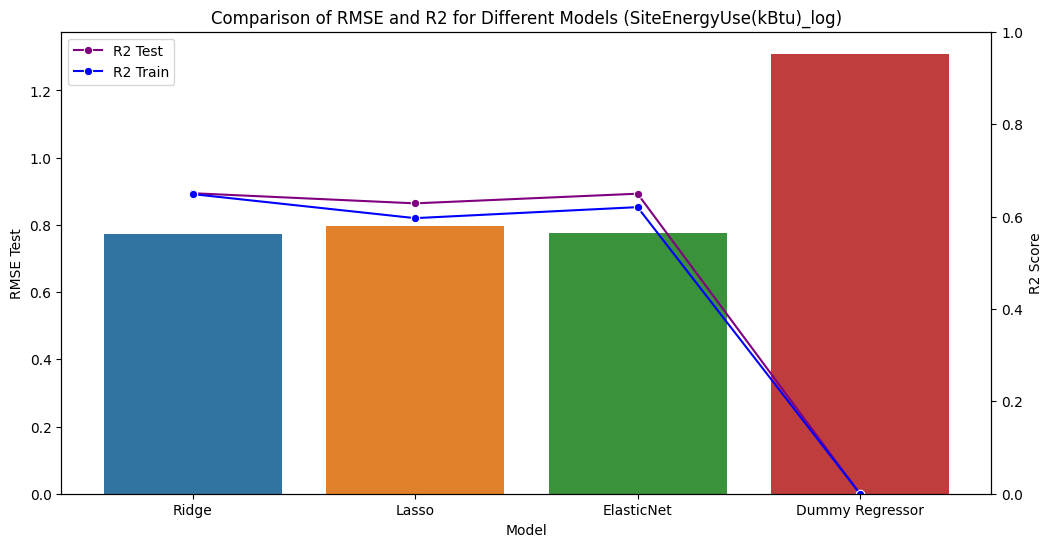

In [74]:
# Fonction pour visualiser les résultats
def plot_results(results, title):
    models = list(results.keys())
    rmse_test_scores = [scores['RMSE_Test'] for scores in results.values()]
    r2_test_scores = [scores['R2_Test'] for scores in results.values()]
    r2_train_scores = [scores['R2_Train'] for scores in results.values()]
    results_df = pd.DataFrame({
        'Model': models,
        'RMSE_Test': rmse_test_scores,
        'R2_Test': r2_test_scores,
        'R2_Train': r2_train_scores
    })
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Model', y='RMSE_Test', data=results_df, ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('RMSE Test')
    ax1.set_xlabel('Model')

    ax2 = ax1.twinx()
    sns.lineplot(x='Model', y='R2_Test', data=results_df, marker='o', color='purple', label='R2 Test', ax=ax2)
    sns.lineplot(x='Model', y='R2_Train', data=results_df, marker='o', color='b', label='R2 Train', ax=ax2)
    ax2.set_ylabel('R2 Score')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper left')

    plt.show()

# Visualisation des résultats pour 'SiteEnergyUse(kBtu)_log'
plot_results(site_energy_results, 'Comparison of RMSE and R2 for Different Models (SiteEnergyUse(kBtu)_log)')

## 5. Simulation des modèles complexes : 'RandomForestRegressor', 'DecisionTreeRegressor', 'XGBRegressor', 'CatBoostRegressor' et 'GradientBoostingRegressor':

### 5. 1. Sélection des variables explicatives et des variables cibles

In [75]:
X = data.drop(['SiteEnergyUse(kBtu)_log', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)
y_site_energy = data['SiteEnergyUse(kBtu)_log']

### 5. 2. Encodage et standardisation:

In [76]:
numeric_features = X.select_dtypes(include=['int32','int64','float64']).columns
categorical_features = X.select_dtypes(exclude=['int32','int64','float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation des valeurs manquantes avec la moyenne
    # ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes avec la médiane
    ('scaler', StandardScaler())
    # ('scaler', RobustScaler())  # Utilisation de RobustScaler à la place de StandardScaler
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### 5. 3. Fonction pour créer les pipelines:

In [77]:
def create_pipeline(regressor, params):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    return GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', refit=True)

### 5. 4. Liste des modèles avec leurs paramètres pour GridSearchCV:

In [78]:
models = {
    'RandomForest': (RandomForestRegressor(), {
        'regressor__n_estimators': [200, 250, 300],
        'regressor__max_depth': [30, 35, 40]
    }),
    'DecisionTree': (DecisionTreeRegressor(), {
        'regressor__max_depth': [10, 15, 20],
        'regressor__min_samples_split': [20, 25, 30],
        'regressor__min_samples_leaf': [5, 7, 10]
    }),
    'XGBoost': (XGBRegressor(), {
        'regressor__n_estimators': [100, 150, 200],
        'regressor__learning_rate': [0.1, 0.15, 0.2],
        'regressor__max_depth': [3, 4, 5]
    }),
    'CatBoost': (CatBoostRegressor(silent=True), {
        'regressor__iterations': [300, 350, 400],
        'regressor__learning_rate': [0.05, 0.1, 0.15],
        'regressor__depth': [4, 5, 6]
    }),
    'GradientBoosting': (GradientBoostingRegressor(), {
        'regressor__n_estimators': [100, 150, 200],
        'regressor__learning_rate': [0.05, 0.1, 0.15],
        'regressor__max_depth': [3, 4, 5]
    })
}


### 5. 5. La fonction pour l'évaluation des modèles pour la variable cible:

In [79]:
# Division des données en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y_site_energy, test_size=0.2, 
                                                    stratify=pd.qcut(y_site_energy, q=5, labels=False), 
                                                    random_state=42)

In [80]:
def evaluate_models(X_train, X_test, y_train, y_test, best_model=False, best_model_name=None, models=None):
    results = {}

    if best_model:
        if best_model_name is not None:
            model, params = models[best_model_name]
            pipeline = create_pipeline(model, params)
            pipeline.fit(X_train, y_train)
            y_pred_test = pipeline.predict(X_test)
            y_pred_train = pipeline.predict(X_train)
            rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
            r2_test = r2_score(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            best_estimator = pipeline.best_estimator_.named_steps['regressor']
            results[best_model_name] = {
                'RMSE_Test': rmse_test,
                'R2_Test': r2_test,
                'R2_Train': r2_train,
                'Best_Params': pipeline.best_params_,
                'Model': best_estimator,
                'pipeline': pipeline,
                'Preprocessor': pipeline.best_estimator_.named_steps['preprocessor'],
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
        else:
            raise ValueError("best_model_name must be provided when best_model is True.")
    else:
        for name, (model, params) in models.items():
            pipeline = create_pipeline(model, params)
            pipeline.fit(X_train, y_train)
            y_pred_test = pipeline.predict(X_test)
            y_pred_train = pipeline.predict(X_train)
            rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
            r2_test = r2_score(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            best_estimator = pipeline.best_estimator_.named_steps['regressor']
            results[name] = {
                'RMSE_Test': rmse_test,
                'R2_Test': r2_test,
                'R2_Train': r2_train,
                'Best_Params': pipeline.best_params_,
                'Model': best_estimator,
                'pipeline': pipeline,
                'Preprocessor': pipeline.best_estimator_.named_steps['preprocessor'],
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }

    return results

### 5. 6. La fonction pour la sélection du meilleur modèle:

In [81]:
def select_best_model(results):
    best_model = min(results, key=lambda k: results[k]['RMSE_Test'])
    best_model_details = results[best_model]
    return best_model, best_model_details

### 5. 7. Evaluation des modèles et la sélection du meilleur modèle pour la cible 'SiteEnergyUse(kBtu)_log':

In [82]:
# Évaluation des modèles pour 'SiteEnergyUse(kBtu)_log'
site_energy_results = evaluate_models(X_train, X_test, y_train, y_test, models=models)
print("Results for SiteEnergyUse(kBtu)_log:")
for model, scores in site_energy_results.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")

Results for SiteEnergyUse(kBtu)_log:
RandomForest - RMSE Test: 0.6429551477562666, R2 Test: 0.7588529208632767, R2 Train: 0.9609001541381573, Best Params: {'regressor__max_depth': 30, 'regressor__n_estimators': 200}
DecisionTree - RMSE Test: 0.7725245004721901, R2 Test: 0.6518670148198553, R2 Train: 0.7549493099839014, Best Params: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 7, 'regressor__min_samples_split': 30}
XGBoost - RMSE Test: 0.6143291775606806, R2 Test: 0.7798478477369701, R2 Train: 0.8948690788996464, Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 150}
CatBoost - RMSE Test: 0.6013910496791623, R2 Test: 0.7890232630756996, R2 Train: 0.8822745233743254, Best Params: {'regressor__depth': 6, 'regressor__iterations': 400, 'regressor__learning_rate': 0.05}
GradientBoosting - RMSE Test: 0.6079832838245361, R2 Test: 0.7843726091605301, R2 Train: 0.8303482053048195, Best Params: {'regressor__learning_rate': 0.05, 'r

**Conclusion :**

Les modèles RandomForest et DecisionTree montrent des signes de surapprentissage, avec RandomForest étant le plus affecté. Les modèles XGBoost, CatBoost, et GradientBoosting montrent un meilleur équilibre entre les ensembles d'entraînement et de test, suggérant une meilleure généralisation.

- **CatBoost** se distingue par ses performances solides et son excellent équilibre entre les ensembles d'entraînement et de test.
- **XGBoost** offre également de bonnes performances et une bonne capacité de généralisation.
- **GradientBoosting** est bien équilibré et performant.

En conclusion, CatBoost est le meilleur modèle, suivi de près par XGBoost et GradientBoosting.

### 5. 8. Visualisation des résultats:

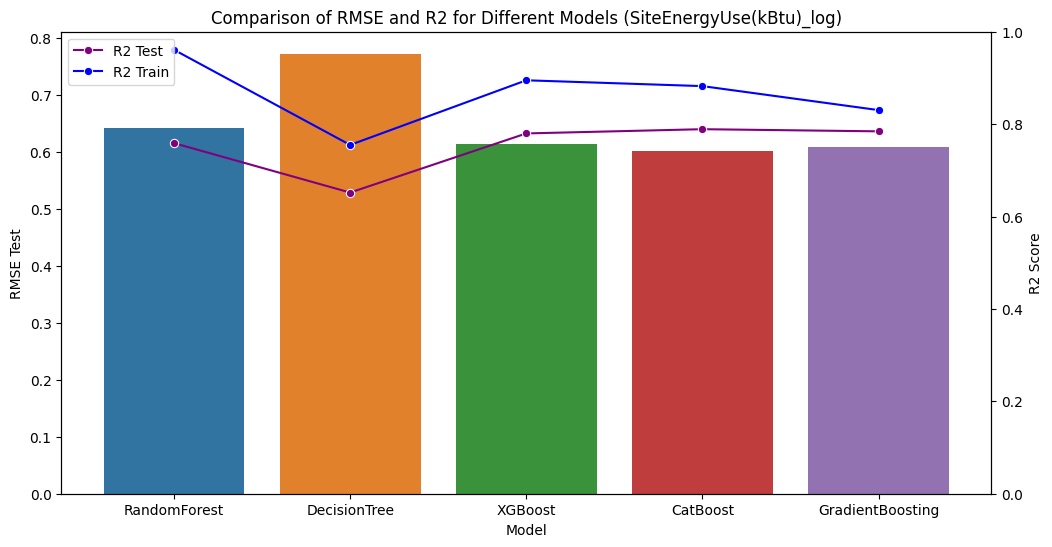

In [83]:
# Visualisation des résultats pour 'SiteEnergyUse(kBtu)_log'
plot_results(site_energy_results, 'Comparison of RMSE and R2 for Different Models (SiteEnergyUse(kBtu)_log)')

### 5. 9. Sélectionner le meilleur modèle :

In [84]:
# Sélection du meilleur modèle
best_model_site_energy, best_model_site_energy_details = select_best_model(site_energy_results)
print(f"\nBest model for SiteEnergyUse(kBtu)_log: {best_model_site_energy} with RMSE Test: {best_model_site_energy_details['RMSE_Test']}, R2 Test: {best_model_site_energy_details['R2_Test']}, R2 Train: {best_model_site_energy_details['R2_Train']}")


Best model for SiteEnergyUse(kBtu)_log: CatBoost with RMSE Test: 0.6013910496791623, R2 Test: 0.7890232630756996, R2 Train: 0.8822745233743254


**Conclusion:**   CatBoost est le meilleur modèle.

## 6. Fine-tuning de ce meilleur modèle:

#### 6. 1. Trouver les meilleurs hyperparamètres:

In [85]:
# Transformer les données d'entraînement en utilisant le préprocesseur du pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed_array = X_train_transformed.toarray() if hasattr(X_train_transformed, 'toarray') else X_train_transformed

X_test_transformed = preprocessor.transform(X_test)
X_test_transformed_array = X_test_transformed.toarray() if hasattr(X_test_transformed, 'toarray') else X_test_transformed

In [86]:
# Mise à jour des hyperparamètres pour un fine-tuning plus ciblé
models = {
    'CatBoost': (CatBoostRegressor(random_state=42, verbose=0), {
        'iterations': np.arange(480, 520, 5),  
        'learning_rate': np.linspace(0.045, 0.055, 11),  
        'depth': [5, 6, 7],  
        'l2_leaf_reg': np.linspace(0.5, 3.0, 6),  
        'bagging_temperature': np.linspace(0.1, 0.4, 4),  
        'border_count': [50, 100, 150, 200],  
        'boosting_type': ['Plain'],  
        'rsm': [0.8, 0.85, 0.9, 0.95, 1.0] 
    })
}

# Préprocesseur et données d'entraînement
preprocessor = best_model_site_energy_details['Preprocessor']

# Fine-tuning pour chaque modèle
for model_name, (model, param_dist) in models.items():
    print(f"Fine-tuning pour le modèle: {model_name}")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=150,  # Augmentation du nombre d'itérations
        scoring='neg_mean_squared_error',
        cv=10,  # Augmentation de la validation croisée
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Ajuster le modèle
    random_search.fit(X_train_transformed, y_train)
    
    # Meilleurs hyperparamètres et RMSE
    rmse = np.sqrt(-random_search.best_score_)
    print(f"Meilleur RMSE obtenu : {rmse:.4f}")
    print(f"Meilleurs hyperparamètres pour {model_name}: {random_search.best_params_}")


Fine-tuning pour le modèle: CatBoost
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Meilleur RMSE obtenu : 0.6840
Meilleurs hyperparamètres pour CatBoost: {'rsm': 0.8, 'learning_rate': 0.054, 'l2_leaf_reg': 0.5, 'iterations': 495, 'depth': 5, 'border_count': 150, 'boosting_type': 'Plain', 'bagging_temperature': 0.2}


In [87]:
params = random_search.best_params_

In [88]:
params

{'rsm': 0.8,
 'learning_rate': 0.054,
 'l2_leaf_reg': 0.5,
 'iterations': 495,
 'depth': 5,
 'border_count': 150,
 'boosting_type': 'Plain',
 'bagging_temperature': 0.2}

In [89]:
models_fine_tuning = {
    'CatBoost': (CatBoostRegressor(random_state=42, verbose=0), {
        'regressor__iterations': [params['iterations']],
        'regressor__learning_rate': [params['learning_rate']],
        'regressor__depth': [params['depth']],
        'regressor__l2_leaf_reg': [params['l2_leaf_reg']],
        'regressor__bagging_temperature': [params['bagging_temperature']],
        'regressor__border_count': [params['border_count']],
        'regressor__boosting_type': [params['boosting_type']],
        'regressor__rsm': [params['rsm']]
    })
}


### 6. 2. Results after fine-tuning:

In [90]:
site_energy_results_fine_tuning = evaluate_models(X_train, X_test, y_train, y_test, best_model=True, best_model_name=best_model_site_energy, models=models_fine_tuning)
print("\nResults for SiteEnergyUse(kBtu)_log after fine_tuning:")
for model, scores in site_energy_results_fine_tuning.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")


Results for SiteEnergyUse(kBtu)_log after fine_tuning:
CatBoost - RMSE Test: 0.5888665628046791, R2 Test: 0.7977193037024772, R2 Train: 0.9159274731188091, Best Params: {'regressor__bagging_temperature': 0.2, 'regressor__boosting_type': 'Plain', 'regressor__border_count': 150, 'regressor__depth': 5, 'regressor__iterations': 495, 'regressor__l2_leaf_reg': 0.5, 'regressor__learning_rate': 0.054, 'regressor__rsm': 0.8}


Donc le best model final: 

In [91]:
best_model_final = site_energy_results_fine_tuning['CatBoost']['Model']

**Conclusion :**

Le modèle CatBoost a montré de bonnes performances avant le fine-tuning avec un RMSE de 0.601 et des scores R2 de 0.789 en test et 0.882 en entraînement. Après le fine-tuning, les performances ont été encore améliorées, abaissant le RMSE à 0.588 et augmentant les scores R2 à 0.797 en test et 0.915 en entraînement. Ces résultats démontrent une précision accrue et une meilleure capacité de généralisation, bien que le surapprentissage ait légèrement augmenté. CatBoost se confirme ainsi comme un outil efficace pour la prévision de la consommation énergétique des bâtiments.

<!-- **Conclusion:**

Les résultats montrent que le modèle CatBoostRegressor simplifié offre des performances raisonnables, avec un score R² moyen en validation croisée de 0.7065 ± 0.0227, un score R² sur l'ensemble de test de 0.7718, et un score R² sur l'ensemble d'entraînement de 0.8051. Le RMSE sur l'ensemble de test est de 0.6254. -->

## 7. Analyse de la « feature importance » locale:

In [92]:
import shap

shap.initjs()

In [93]:
# Définir la ligne sur la quelle on applique l'analyse locale
row = 3

# Création de l'explicateur SHAP en utilisant le modèle entraîné
explainer = shap.Explainer(best_model_final)
shap_values = explainer(X_test_transformed_array, check_additivity=False )

# Affichage de la force plot pour le premier échantillon de X_train_transformed
shap.plots.force(shap_values[row], feature_names=X_test.columns)


<!-- #### Conclusion sur l'Analyse de la « Feature Importance » Locale

L'analyse locale de l'importance des caractéristiques (feature importance) présentée dans l'image fournit une explication détaillée sur la contribution des différentes caractéristiques pour une prédiction spécifique du modèle. Voici les principales observations :

1. **Valeur de Base (Base Value)** :
   - La valeur de base est le point de départ pour la prédiction, représentée par le chiffre central sur l'échelle (14.98). Cela correspond à la valeur moyenne prédite par le modèle.

2. **Caractéristiques qui Augmentent la Prédiction (Higher - Rouge)** :
   - **ThirdLargestPropertyUseType = 0.6226** : Cette caractéristique a contribué à augmenter la valeur prédite de 0.6226. Cela indique que la présence ou la valeur de cette caractéristique dans l'observation a un effet positif sur la prédiction finale.
   - **PrimaryPropertyType** : Contribue également à l'augmentation de la valeur prédite de 0.6724. Cela indique que la présence ou la valeur de cette caractéristique dans l'observation a un effet positif sur la prédiction finale.

3. **Caractéristiques qui Diminuent la Prédiction (Lower - Bleu)** :
   - **TotalUseTypeNumber = -0.6434** : Cette caractéristique a diminué la valeur prédite de 0.6434, suggérant qu'un plus grand nombre de types d'utilisation totale a un effet négatif sur la prédiction.
   - **ElectricityUseCategory_PrimaryPropertyType = 1** : La catégorie d'utilisation de l'électricité pour le type de propriété principal a un effet négatif sur la prédiction.
   - **BuildingAge = -0.512** : L'âge du bâtiment a réduit la valeur prédite de 0.512, indiquant que les bâtiments plus anciens tendent à réduire cette prédiction spécifique.


- **Contribution des Caractéristiques** :
  - Les caractéristiques en rouge ont un effet positif et augmentent la prédiction par rapport à la valeur de base. Dans ce cas, **ThirdLargestPropertyUseType** est la caractéristique la plus influente qui augmente la prédiction.
  - Les caractéristiques en bleu ont un effet négatif et diminuent la prédiction par rapport à la valeur de base. **TotalUseTypeNumber** et **BuildingAge** sont les caractéristiques les plus influentes qui réduisent la prédiction.


En conclusion, cette analyse locale de l'importance des caractéristiques montre comment chaque caractéristique contribue individuellement à la prédiction finale du modèle, fournissant ainsi une explication claire et détaillée des décisions du modèle pour une observation spécifique. -->

### **Observation :**

Le modèle CatBoost a prédit une consommation d'énergie de 15.03 (`SiteEnergyUse(kBtu)_log`). Cette prédiction résulte des contributions individuelles de diverses caractéristiques, illustrées par le graphique de force SHAP.

#### **Analyse détaillée des contributions des caractéristiques :**

1. **Contributions augmentant la prédiction** (colorées en rouge) :
   - **LargestPropertyUseType** : L'utilisation principale du bâtiment augmente significativement la prédiction, indiquant une consommation énergétique plus élevée pour ce type d'utilisation.
   - **ThirdLargestPropertyUseType** : Ce troisième type d'utilisation principale du bâtiment augmente également la prédiction, suggérant une consommation d'énergie plus élevée liée à cette utilisation spécifique.


2. **Contributions diminuant la prédiction** (colorées en bleu) :
   - **PrimaryPropertyType** : Cette caractéristique réduit la prédiction, ce qui suggère que certains types de propriétés sont associés à des consommations d'énergie inférieures.
   - **Neighborhood** : La localisation du bâtiment dans un quartier spécifique contribue à réduire la prédiction, ce qui peut refléter des pratiques énergétiques plus efficaces ou des politiques locales favorables.
   - **TotalUseTypeNumber** : Le nombre élevé d'utilisations différentes dans le bâtiment est associé à une efficacité énergétique supérieure, réduisant ainsi la prédiction globale.
   - **NaturalGasUseCategory_BuildingType** : Bien que cette caractéristique montre une légère augmentation (position plus à gauche sur le graphique), sa couleur bleue indique qu'elle contribue à la réduction de la prédiction.

### **Conclusion**

La prédiction de 15.03 pour la consommation d'énergie est principalement augmentée par des facteurs tels que l'utilisation principale et le troisième type d'utilisation principale du bâtiment, qui indiquent des niveaux de consommation d'énergie plus élevés. Inversement, le type principal de propriété, le quartier, le nombre et la diversité des utilisations du bâtiment, ainsi que certains usages du gaz naturel jouent un rôle significatif dans la réduction de la prédiction. Cette analyse SHAP révèle des insights précieux sur les facteurs influençant la consommation énergétique, fournissant une base solide pour l'optimisation des stratégies énergétiques des bâtiments.

## 8. Analyse de la « feature importance » globale:

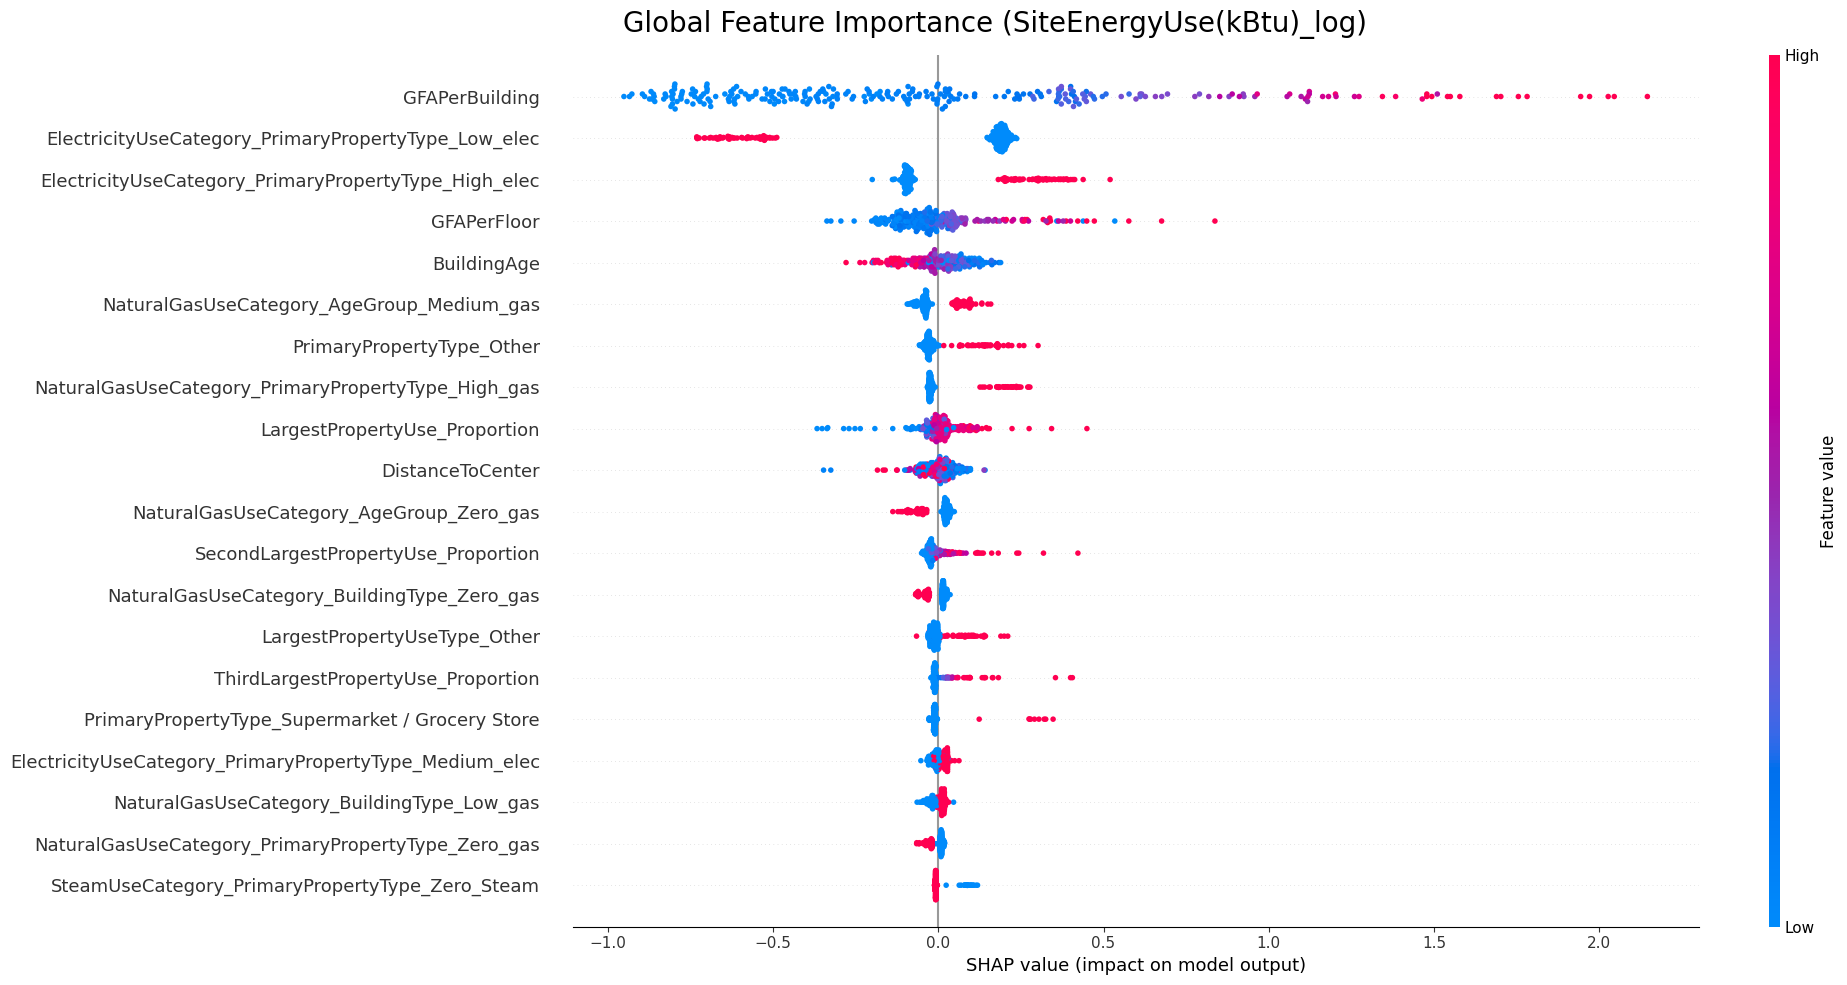

In [94]:
# Convertir la liste des caractéristiques numériques en une liste Python normale
numeric_feature_names = numeric_features.tolist()

# Obtenir les noms des caractéristiques catégorielles après encodage one-hot
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()

# Combiner les noms des caractéristiques numériques et catégorielles
feature_names = numeric_feature_names + categorical_feature_names

# Créer une figure avec une taille spécifiée
fig, ax = plt.subplots(figsize=(35, 35))

# Ajouter un titre à la figure
fig.suptitle('Global Feature Importance (SiteEnergyUse(kBtu)_log)', fontsize=20)

# Afficher le graphique résumé des valeurs SHAP
shap.summary_plot(shap_values, features=X_test_transformed_array, feature_names=feature_names, plot_size=(20, 10), show=False)


# Ajuster l'affichage
plt.tight_layout()

# Afficher le plot
plt.show()


<!-- Les graphiques montrent l'importance des caractéristiques globales pour les modèles de prédiction de la consommation d'énergie du site (SiteEnergyUse(kBtu)_log)  respectivement. Voici quelques observations et suggestions :

### Observations :

**Importance des caractéristiques** :
   - **SiteEnergyUse(kBtu)_log** : Les caractéristiques comme `GFAPerBuilding`, `NumberofFloors`, et `BuildingAge` semblent avoir un impact significatif sur le modèle. D'autres caractéristiques comme `Latitude`, `ZipCode`, et `Longitude` montrent également une importance non négligeable.
   - **TotalGHGEmissions_log** : Les caractéristiques `GFAPerBuilding`, `ElectricityUseCategory_PrimaryPropertyType_Medium_elec`, et `ElectricityUseCategory_BuildingType_Medium_elec` sont parmi les plus importantes. D'autres comme `BuildingAge`, `NumberofBuildings`, et divers types d'utilisation des propriétés montrent également une importance notable.


### Conclusion :

Les visualisations sont claires et bien présentées, montrant efficacement l'importance des différentes caractéristiques dans ces modèles de prédiction. Les graphiques peuvent être utilisés pour identifier les caractéristiques les plus influentes et pour guider des analyses plus approfondies.  -->

### Observation de l'analyse Globale de l'Importance des Caractéristiques:

L'analyse de l'importance globale des caractéristiques pour la prédiction de la consommation d'énergie du site (`SiteEnergyUse(kBtu)_log`) révèle les caractéristiques les plus influentes en utilisant les valeurs SHAP (SHapley Additive exPlanations). Ces caractéristiques sont essentielles pour comprendre les facteurs qui augmentent ou réduisent la consommation d'énergie.

#### **Caractéristiques Principales :**

1. **GFA Per Building (Surface de Plancher Par Bâtiment)**
   - **Impact**: Très influent avec un effet majoritairement positif, indiquant que de plus grandes surfaces de plancher augmentent généralement la consommation d'énergie.

2. **Electricity Use Category for Primary Property Type - High and Low Electricity Use**
   - **Impact**: Ces catégories d'utilisation de l'électricité selon le type de propriété influencent significativement la prédiction. Une haute consommation d'électricité augmente la prédiction tandis qu'une faible consommation la diminue.

3. **GFA Per Floor (Surface de Plancher Par Étage)**
   - **Impact**: Exerce une grande influence positive, corroborant que des étages plus grands tendent à consommer plus d'énergie.

4. **Natural Gas Use Category for Primary Property Type - High Gas Use**
   - **Impact**: Fortement positif, illustrant que des niveaux élevés de consommation de gaz naturel pour certains types de propriétés augmentent la consommation d'énergie.

5. **Natural Gas Use Category for Building Type - Zero Gas Use**
   - **Impact**: Effet négatif marqué, montrant que l'absence de consommation de gaz dans certains types de bâtiments réduit la consommation d'énergie.

6. **Largest Property Use - Proportion**
   - **Impact**: Impact modéré indiquant que la proportion de l'utilisation principale du bâtiment affecte la consommation d'énergie.

7. **Building Age**
   - **Impact**: Influence négative, suggérant que les bâtiments plus anciens peuvent consommer moins d'énergie, ce qui pourrait refléter des constructions moins énergivores ou des rénovations énergétiques.

8. **Electricity Use Category - Medium Electricity Use**
   - **Impact**: Effet positif modéré, montrant que des niveaux moyens de consommation d'électricité contribuent à une augmentation de la consommation d'énergie.

9. **Natural Gas Use Category for Age Group - Medium Gas Use**
   - **Impact**: Effet modéré positif, indiquant que la consommation moyenne de gaz par certains groupes d'âge augmente également la consommation d'énergie.

10. **Primary Property Type - Other**
    - **Impact**: Modérément influent, couvrant des types de propriétés variés qui présentent une consommation énergétique significative.

### Conclusion:

Cette analyse SHAP démontre que la **surface de plancher par bâtiment** et les **catégories d'utilisation de l'électricité et du gaz naturel** sont des déterminants clés de la consommation d'énergie. **L'âge du bâtiment** et **la proportion des usages principaux du bâtiment** ont également un rôle modéré mais notable. Ces insights sont cruciaux pour identifier des moyens d'améliorer l'efficacité énergétique et pour cibler des interventions spécifiques adaptées aux caractéristiques de chaque bâtiment.

## 9. Analyse de l’influence de l’EnergyStarScore:

#### Pour la variable cible SiteEnergyUse(kBtu)_log:

On avait trouvé que le meilleur model pour la variable cible  est le modèle: 

In [102]:
models_fine_tuning

{'CatBoost': (<catboost.core.CatBoostRegressor at 0x27384eae7a0>,
  {'regressor__iterations': [495],
   'regressor__learning_rate': [0.054],
   'regressor__depth': [5],
   'regressor__l2_leaf_reg': [0.5],
   'regressor__bagging_temperature': [0.2],
   'regressor__border_count': [150],
   'regressor__boosting_type': ['Plain'],
   'regressor__rsm': [0.8]})}

In [103]:
# Charger les dtypes depuis le fichier JSON
with open("Data/dtypes_EnergyUse.json", "r") as f:
    dtypes_dict = json.load(f)

df_test= pd.read_csv("Data/building-EnergyUse-cleaned.csv", dtype=dtypes_dict)
df_test = df_test.dropna(subset=['ENERGYSTARScore'])

X_sans_ENERGYSTARScore = df_test.drop(['SiteEnergyUse(kBtu)_log', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)
y_site_energy = df_test['SiteEnergyUse(kBtu)_log']

In [104]:
X_train_sans_ENERGYSTARScore, X_test_sans_ENERGYSTARScore, y_train_sans_ENERGYSTARScore, y_test_sans_ENERGYSTARScore = train_test_split(X_sans_ENERGYSTARScore, y_site_energy, test_size=0.2, 
                                                    stratify=pd.qcut(y_site_energy, q=5, labels=False), 
                                                    random_state=42)

In [105]:
site_energy_results_sans_EnergyStarScore = evaluate_models(X_train_sans_ENERGYSTARScore, X_test_sans_ENERGYSTARScore, y_train_sans_ENERGYSTARScore, y_test_sans_ENERGYSTARScore, best_model=True, best_model_name=best_model_site_energy, models=models_fine_tuning)
print("Results for SiteEnergyUse(kBtu):")
for model, scores in site_energy_results_sans_EnergyStarScore.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")

Results for SiteEnergyUse(kBtu):
CatBoost - RMSE Test: 0.5338628029890861, R2 Test: 0.8241203751675885, R2 Train: 0.958022647555469, Best Params: {'regressor__bagging_temperature': 0.2, 'regressor__boosting_type': 'Plain', 'regressor__border_count': 150, 'regressor__depth': 5, 'regressor__iterations': 495, 'regressor__l2_leaf_reg': 0.5, 'regressor__learning_rate': 0.054, 'regressor__rsm': 0.8}


on va comparer avec le même modèle ce resultat en avec le resultat en intégrant dans les variables explicatives la variable EnergyStarScore:

In [106]:
X_ENERGYSTARScore = df_test.drop(['SiteEnergyUse(kBtu)_log', 'OSEBuildingID'], axis=1)
y_site_energy = df_test['SiteEnergyUse(kBtu)_log']

In [107]:
X_train_ENERGYSTARScore, X_test_ENERGYSTARScore, y_train_ENERGYSTARScore, y_test_ENERGYSTARScore = train_test_split(X_ENERGYSTARScore, y_site_energy, test_size=0.2, 
                                                    stratify=pd.qcut(y_site_energy, q=5, labels=False), 
                                                    random_state=42)

In [108]:
site_energy_results_EnergyStarScore = evaluate_models(X_train_ENERGYSTARScore, X_test_ENERGYSTARScore, y_train_ENERGYSTARScore, y_test_ENERGYSTARScore, best_model=True, best_model_name=best_model_site_energy, models=models_fine_tuning)
print("Results for SiteEnergyUse(kBtu):")
for model, scores in site_energy_results_EnergyStarScore.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")

Results for SiteEnergyUse(kBtu):
CatBoost - RMSE Test: 0.5338628029890861, R2 Test: 0.8241203751675885, R2 Train: 0.958022647555469, Best Params: {'regressor__bagging_temperature': 0.2, 'regressor__boosting_type': 'Plain', 'regressor__border_count': 150, 'regressor__depth': 5, 'regressor__iterations': 495, 'regressor__l2_leaf_reg': 0.5, 'regressor__learning_rate': 0.054, 'regressor__rsm': 0.8}


### **Conclusion :**

L'analyse des performances du modèle CatBoost pour la prédiction de la consommation d'énergie (SiteEnergyUse(kBtu)) montre que l'ajout de l'EnergyStarScore ne modifie pas les résultats obtenus. Les performances avec ou sans cette variable sont les suivantes :

- **RMSE Test** : 0.5339
- **R² Test** : 0.8241
- **R² Train** : 0.9580

Ces résultats indiquent que l'intégration de l'EnergyStarScore n'a pas eu d'impact sur la précision ou la généralisation du modèle. En dépit des attentes, cette variable ne semble pas ajouter de valeur significative pour améliorer les prédictions de la consommation d'énergie des bâtiments dans ce cas spécifique. 

<!-- Results for SiteEnergyUse(kBtu):
GradientBoosting - RMSE Test: 0.5608709631325479, R2 Test: 0.8058747092034196, R2 Train: 0.8987554706864063, Best Params: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 50} -->

<!-- On remarque que l'ajout de la variable EnergyStarScore dans la liste des variables explicatives a eu une légère influence sur les performances du modèle CatBoost pour la variable cible SiteEnergyUse(kBtu)_log. Le R² est passé de 0,78 à 0,80 et le MSE de 0,37 à 0,30, indiquant une amélioration de la précision du modèle. -->